In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [3]:
#Merged data from the diagnostics.csv and faults.csv
combined = pd.read_csv("../big_g_express-domo-arigato-mr-robot/combined.csv")

/home/evgeniya/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
combined['EventTimeStamp'] = pd.to_datetime(combined['EventTimeStamp'])
combined["EquipmentID"]= combined["EquipmentID"].astype(str)
#fully_derated = combined[(combined["spn"]==5246) & (combined["fmi"]==0 )]

In [5]:
#fully_derated_preceding = combined.loc[combined['EquipmentID'].isin(fully_derated['EquipmentID']), :]

In [6]:
combined['fully_derated'] = np.where((combined['spn'] ==5246) & (combined['fmi'] ==0), 1, 0)

In [7]:
combined.head()

,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,...,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,fully_derated
0,0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,...,False,78.8,1023.0,True,NaN,0.0,3276.75,NaN,0.0,0
1,1,2,990360,2015-02-21 11:34:34,NaN,NaN,unknown,unknown,unknown,unknown,...,True,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,3,990364,2015-02-21 11:35:31,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,...,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,4,990370,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,...,True,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,5,990416,2015-02-21 11:39:41,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,...,NaN,NaN,16639.0,NaN,NaN,NaN,NaN,NaN,NaN,0


## ADD FIRST DERATE DATE FOR FULLY DERATED TRUCKS PER A TRUCK

In [8]:
combined.shape

(1187335, 49)

In [9]:
combined_min_date = combined.loc[combined['fully_derated'] ==1].groupby('EquipmentID').agg({'EventTimeStamp' : 'min'}).reset_index()

In [10]:
combined_min_date.rename(columns={'EventTimeStamp': 'first_derate_date'}, inplace=True)

In [11]:
combined = combined.sort_values(by = ['EventTimeStamp', 'EquipmentID'], ascending = [True, True])

In [12]:
combined_min_date.sort_values(by = ['first_derate_date', 'EquipmentID'], ascending = [True, True])

,EquipmentID,first_derate_date
200,2175,2011-01-01 00:03:23
118,1751,2011-01-01 00:03:34
29,1452,2011-01-01 00:04:57
14,1395,2015-02-21 12:10:51
92,1630,2015-02-23 05:05:44
...,...,...
177,1947,2019-09-30 04:56:43
196,2089,2019-11-01 18:07:51
202,2211,2020-02-03 16:34:21
150,1854,2020-02-06 07:45:08


In [13]:
combined = combined.merge(combined_min_date, on = ['EquipmentID'], how = 'left')

In [14]:
#indicate when truck id changes
combined['flipper'] = np.where((combined.EquipmentID != combined.EquipmentID.shift(1)), 1, 0)

In [15]:
combined = combined[combined['EquipmentID'].str.len()<6]

In [16]:
combined = combined[~((combined['Longitude'].astype('str').str.contains(r'-86.44\d+')) & (combined['Latitude'].astype('str').str.contains(r'-36.06\d+')))]

In [17]:
combined = combined[~((combined['Longitude'].astype('str').str.contains(r'-86.44\d+')) & (combined['Latitude'].astype('str').str.contains(r'-35.58\d+')))]

In [18]:
combined = combined[~((combined['Longitude'].astype('str').str.contains(r'-83.17\d+')) & (combined['Latitude'].astype('str').str.contains(r'-36.19\d+')))]

In [19]:
combined.shape

(1185166, 51)

In [20]:
seven_days = datetime.timedelta(days=7)

## ADD SEVEN DAYS BEFORE DERATE TIME Column

In [21]:
combined['seven_days_before_derate'] = combined['first_derate_date'] - seven_days

In [22]:
combined['partially_derated'] = np.where((combined['spn'] ==1569) & (combined['fmi'] ==31), 1, 0)

In [23]:
## PULL PARTIALLY AND FULLY DERATED (dfx)

In [24]:
dfx = combined[(combined['fully_derated'] ==1) | (combined['partially_derated']==1)]

In [25]:
## check if partially derated trucks are in fully derated subset
#looks like all partially derated are in fully_derated
fdx = combined[combined['fully_derated'] ==1]
pdx = combined[combined['partially_derated'] ==1]
#res = fdx.EquipmentID.intersection(pdx.EquipmentID)


In [26]:
dfx.loc[:,['EquipmentID', 'EventTimeStamp', 'spn','flipper']]

,EquipmentID,EventTimeStamp,spn,flipper
41,1968,2000-03-19 14:02:34,1569,1
352,2175,2011-01-01 00:03:23,5246,1
359,1751,2011-01-01 00:03:34,1569,1
360,1751,2011-01-01 00:03:34,5246,0
379,1452,2011-01-01 00:04:57,5246,0
...,...,...,...,...
1186070,1855,2020-03-02 15:51:18,1569,1
1186197,1827,2020-03-03 06:51:50,1569,0
1186208,1827,2020-03-03 06:59:13,1569,0
1186721,1868,2020-03-04 16:55:48,1569,1


In [27]:
#fdx.loc[~(fdx['EquipmentID'].isin(pdx)),['EquipmentID', 'EventTimeStamp', 'spn']]

In [28]:
# partially & fully combined preceding
dfx_preceding = combined.loc[combined['EquipmentID'].isin(dfx['EquipmentID']), :]


## GRAB ALL RECORDS AFTER SEVEN DAY MARK AND BEFORE FIRST DERATE DATE

In [29]:
dfx_preceding.shape

(922077, 53)

In [30]:
#fdx_preceding = fdx_preceding.reset_index().set_index('EventTimeStamp', inplace = True)

In [73]:

dfx_seven_day = dfx_preceding.loc[(dfx_preceding['EventTimeStamp'] <= dfx_preceding['first_derate_date']) & (dfx_preceding['EventTimeStamp']>= dfx_preceding['seven_days_before_derate'])]


In [74]:
dfx_seven_day.shape

(7126, 53)

In [75]:
len(dfx_seven_day['spn'].unique())

106

In [76]:
dfx_seven_day[dfx_seven_day['EquipmentID']=='1872']

,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,...,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,fully_derated,first_derate_date,flipper,seven_days_before_derate,partially_derated
1181564,1181561,1241702,120852581,2020-02-13 08:32:46,Abnormal Update Rate Catalyst Tank Reagent Qua...,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,...,NaN,10.83516,NaN,100.0,0.29,0,2020-02-13 13:32:39,1,2020-02-06 13:32:39,0
1181565,1181562,1241703,120852582,2020-02-13 08:32:46,NaN,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,...,NaN,10.83516,NaN,100.0,0.29,0,2020-02-13 13:32:39,0,2020-02-06 13:32:39,0
1181566,1181563,1241704,120852583,2020-02-13 08:32:46,Condition Exists Engine Protection Torque Derate,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,...,NaN,10.83516,NaN,100.0,0.29,0,2020-02-13 13:32:39,0,2020-02-06 13:32:39,1
1181567,1181564,1241705,120852584,2020-02-13 08:32:46,Abnormal Update Rate Catalyst Tank Level,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,...,NaN,10.83516,NaN,100.0,0.29,0,2020-02-13 13:32:39,0,2020-02-06 13:32:39,0
1181568,1181565,1241706,120852586,2020-02-13 08:32:46,NaN,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,...,NaN,10.83516,NaN,100.0,0.29,0,2020-02-13 13:32:39,0,2020-02-06 13:32:39,0
1181569,1181566,1241707,120852587,2020-02-13 08:32:46,Abnormal Update Rate Catalyst Tank Temperature,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,...,NaN,10.83516,NaN,100.0,0.29,0,2020-02-13 13:32:39,0,2020-02-06 13:32:39,0
1181570,1181567,1241708,120852588,2020-02-13 08:32:46,Abnormal Update Rate Aftertreatment 1 Intake NOx,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,...,NaN,10.83516,NaN,100.0,0.29,0,2020-02-13 13:32:39,0,2020-02-06 13:32:39,0
1181641,1181638,1241779,120884619,2020-02-13 11:32:18,NaN,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,...,NaN,48.69026,NaN,100.0,8.99,0,2020-02-13 13:32:39,1,2020-02-06 13:32:39,0
1181642,1181639,1241780,120884620,2020-02-13 11:32:18,Abnormal Update Rate Aftertreatment 1 Outlet NOx,NaN,04358814*06026985*051718174436*09401683*G1*BDR*,79903054,6X1u13D1500000000,CMMNS,...,NaN,48.69026,NaN,100.0,8.99,0,2020-02-13 13:32:39,0,2020-02-06 13:32:39,0
1181659,1181656,1241797,120890962,2020-02-13 12:08:29,Data May Be Invalid Catalyst Tank Level,NaN,NaN,NaN,NaN,NaN,...,NaN,10.39826,NaN,100.0,1.16,0,2020-02-13 13:32:39,1,2020-02-06 13:32:39,0


In [77]:
dfx_seven_day[dfx_seven_day['EquipmentID']=='1872'][['spn']]

,spn
1181564,3364
1181565,5743
1181566,1569
1181567,1761
1181568,5742
1181569,3031
1181570,3216
1181641,5835
1181642,3226
1181659,1761


In [36]:
dfx_seven_day.columns

Index(['Unnamed: 0', 'RecordID', 'ESS_Id', 'EventTimeStamp',
       'eventDescription', 'actionDescription', 'ecuSoftwareVersion',
       'ecuSerialNumber', 'ecuModel', 'ecuMake', 'ecuSource', 'spn', 'fmi',
       'active', 'activeTransitionCount', 'faultValue', 'EquipmentID',
       'MCTNumber', 'Latitude', 'Longitude', 'LocationTimeStamp', 'day',
       'month', 'Year', 'AcceleratorPedal', 'BarometricPressure',
       'CruiseControlActive', 'CruiseControlSetSpeed', 'DistanceLtd',
       'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
       'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
       'FuelLtd', 'FuelRate', 'FuelTemperature', 'IgnStatus',
       'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure', 'fully_derated', 'first_derate_date', 'flipper',
       'seven_days_before_derate', 'partially_derated'],
      dtype='object')

In [135]:
# calculating cross sectional stats for time delta between spn codes per a truck 
# filtering events that occurred less than 30 times so that stdev is statitically significant
result = []

dfx_seven_day_copy = dfx_seven_day.copy()
dfx_seven_day_copy.sort_values(['EquipmentID', 'EventTimeStamp'], ascending = [True, True], inplace =True)
for spn in dfx_seven_day_copy['spn'].unique():
    temp = dfx_seven_day_copy.loc[dfx_seven_day_copy['spn'] == spn,"EventTimeStamp"].diff()
    if len(temp) ==0:
        continue 
    temp = temp.apply(lambda x: x/np.timedelta64(1, 'D')).fillna(0).astype('int64')
    filtered_temp = temp[temp > 0]
    spn_dev = filtered_temp.std()
    spn_mean=filtered_temp.mean()
    result.append((spn, len(filtered_temp),spn_mean, spn_dev))
spn_stats = pd.DataFrame(result, columns = ['spn','sample_size', 'spn_mean', 'spn_dev'])
spn_stats.loc[spn_stats['sample_size'] > 30,:].sort_values(['spn_dev'], ascending=True)

,spn,sample_size,spn_mean,spn_dev
96,3364,35,16.971429,20.896785
5,111,58,24.879310,40.980559
14,3362,40,36.975000,46.835494
12,3216,45,39.288889,56.725264
11,3226,40,44.650000,64.244944
18,3031,53,33.396226,65.659184
23,1761,48,36.562500,66.029944
40,96,35,45.800000,66.984546
28,5394,36,47.472222,74.667831
41,829,33,48.666667,81.600654


In [141]:
#loop through each spn above for entire dataset to see mean and dev

In [136]:
pip install dataframe-image

     |████████████████████████████████| 1.2 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 304 kB 20.0 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 14.6 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 20.8 MB/s eta 0:00:01


Note: you may need to restart the kernel to use updated packages.


In [137]:
import dataframe_image as dfi

In [138]:
dfi.export(spn_stats.loc[spn_stats['sample_size'] > 30,:].sort_values(['spn_dev'], ascending=True), 'stats.png')

[0419/182819.498719:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0419/182819.588156:INFO:headless_shell.cc(653)] Written to file /tmp/tmpy_lfi__k/temp.png.


In [ ]:
#temp = dfx_seven_day_copy.loc[(dfx_seven_day_copy['spn'] == spn) & (dfx_seven_day_copy['flipper']!=1),"EventTimeStamp"].diff()
    

In [38]:
## !!!! I DID NOT GROUP BY EQUIPMENT ID 

In [79]:
dfx_seven_day[dfx_seven_day['spn']==111]

,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,...,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,fully_derated,first_derate_date,flipper,seven_days_before_derate,partially_derated
612,66,67,991199,2015-02-21 12:25:26,Low (Severity Medium) Engine Coolant Level,NaN,05290170*03015749*051914190353*09400015*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,...,NaN,NaN,NaN,NaN,NaN,0,2015-02-23 05:05:44,1,2015-02-16 05:05:44,0
613,67,68,991200,2015-02-21 12:25:37,Low (Severity High) Engine Coolant Level,NaN,05290170*03015749*051914190353*09400015*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,...,NaN,0.00000,3276.75,0.0,0.58,0,2015-02-23 05:05:44,0,2015-02-16 05:05:44,0
631,82,83,991336,2015-02-21 12:35:04,Low (Severity Medium) Engine Coolant Level,NaN,05290170*03015749*051914190353*09400015*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,...,NaN,NaN,NaN,NaN,NaN,0,2015-02-23 05:05:44,0,2015-02-16 05:05:44,0
632,83,84,991346,2015-02-21 12:35:32,Low (Severity High) Engine Coolant Level,NaN,05290170*03015749*051914190353*09400015*G1*BDR*,79642446,6X1u13D1500000000,CMMNS,...,NaN,NaN,NaN,NaN,NaN,0,2015-02-23 05:05:44,0,2015-02-16 05:05:44,0
1095,545,546,997629,2015-02-22 04:17:04,Low (Severity Low) Engine Coolant Level,NaN,04993120*00021657*082113134117*07700053*I0*BBZ*,79466573,6X1u10D1500000000,CMMNS,...,NaN,NaN,NaN,NaN,NaN,0,2015-02-26 22:24:29,1,2015-02-19 22:24:29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124113,1123779,1175199,92417838,2019-06-29 13:07:01,Low (Severity Medium) Engine Coolant Level,NaN,04358814*06011419*051718174436*09401683*G1*BDR*,79897850,6X1u13D1500000000,CMMNS,...,NaN,NaN,NaN,NaN,NaN,0,2019-07-01 07:00:55,0,2019-06-24 07:00:55,0
1124121,1123789,1175209,92425549,2019-06-29 14:39:37,Low (Severity Medium) Engine Coolant Level,NaN,04358814*06011419*051718174436*09401683*G1*BDR*,79897850,6X1u13D1500000000,CMMNS,...,NaN,64.17599,NaN,100.0,1.16,0,2019-07-01 07:00:55,1,2019-06-24 07:00:55,0
1124122,1123790,1175210,92425761,2019-06-29 14:42:29,Low (Severity Medium) Engine Coolant Level,NaN,04358814*06011419*051718174436*09401683*G1*BDR*,79897850,6X1u13D1500000000,CMMNS,...,NaN,NaN,NaN,NaN,NaN,0,2019-07-01 07:00:55,0,2019-06-24 07:00:55,0
1124140,1123808,1175228,92431482,2019-06-29 16:20:24,Low (Severity Medium) Engine Coolant Level,NaN,04358814*06011419*051718174436*09401683*G1*BDR*,79897850,6X1u13D1500000000,CMMNS,...,NaN,69.29259,NaN,100.0,0.87,0,2019-07-01 07:00:55,1,2019-06-24 07:00:55,0


In [40]:
spns = [1569, 3364, 111, 3362, 3216, 3226, 1761, 96, 3031, 5394, 829]

In [41]:
sensors = dfx_seven_day.loc[dfx_seven_day['spn'].isin(spns)][['EventTimeStamp','AcceleratorPedal', 'BarometricPressure', 'CruiseControlActive',
       'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature',
       'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm',
       'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature',
       'IgnStatus', 'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure']]

In [42]:
sensors.set_index('EventTimeStamp')

,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
EventTimeStamp,,,,,,,,,,,,,,,,,,,,,
2015-02-21 12:25:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,6143.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-21 12:25:37,0.0,14.2100,False,66.48672,238338.1,39.2,26.0,48.72,36.44375,800.500,...,32.0,True,42.8,6143.0,True,NaN,0.00000,3276.75,0.0,0.58
2015-02-21 12:35:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-21 12:35:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-22 04:17:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-13 08:32:46,0.0,14.1375,False,57.78752,477435.4,185.0,11.0,23.20,193.83130,598.500,...,NaN,True,69.8,18431.0,False,NaN,10.83516,NaN,100.0,0.29
2020-02-13 08:32:46,0.0,14.1375,False,57.78752,477435.4,185.0,11.0,23.20,193.83130,598.500,...,NaN,True,69.8,18431.0,False,NaN,10.83516,NaN,100.0,0.29
2020-02-13 08:32:46,0.0,14.1375,False,57.78752,477435.4,185.0,11.0,23.20,193.83130,598.500,...,NaN,True,69.8,18431.0,False,NaN,10.83516,NaN,100.0,0.29


In [43]:
sensors = sensors.fillna(0)

In [44]:
cols =['BarometricPressure', 'EngineCoolantTemperature', 'FuelTemperature','SwitchedBatteryVoltage', 'Throttle']

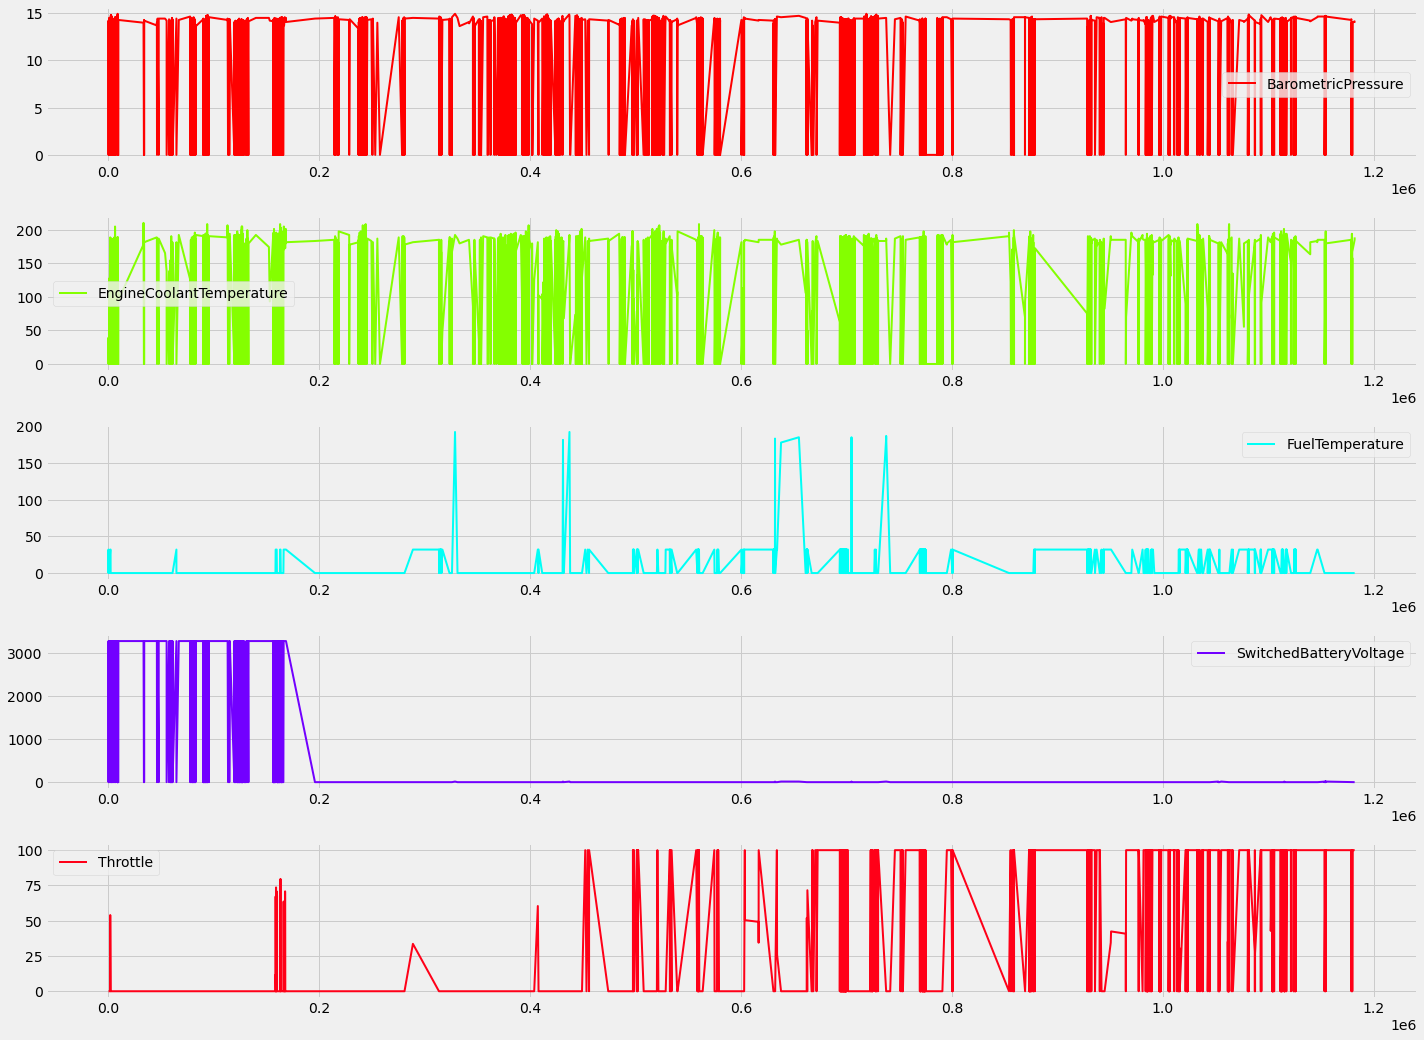

In [45]:
plt.rcParams['figure.figsize'] = (20,20)
plt.style.use('fivethirtyeight')
sensors[['BarometricPressure', 'EngineCoolantTemperature', 'FuelTemperature','SwitchedBatteryVoltage', 'Throttle']].plot(subplots= True,layout=(7,1),sharex=False, sharey=False, colormap='hsv',linewidth = 2);
plt.tight_layout();

<AxesSubplot:>

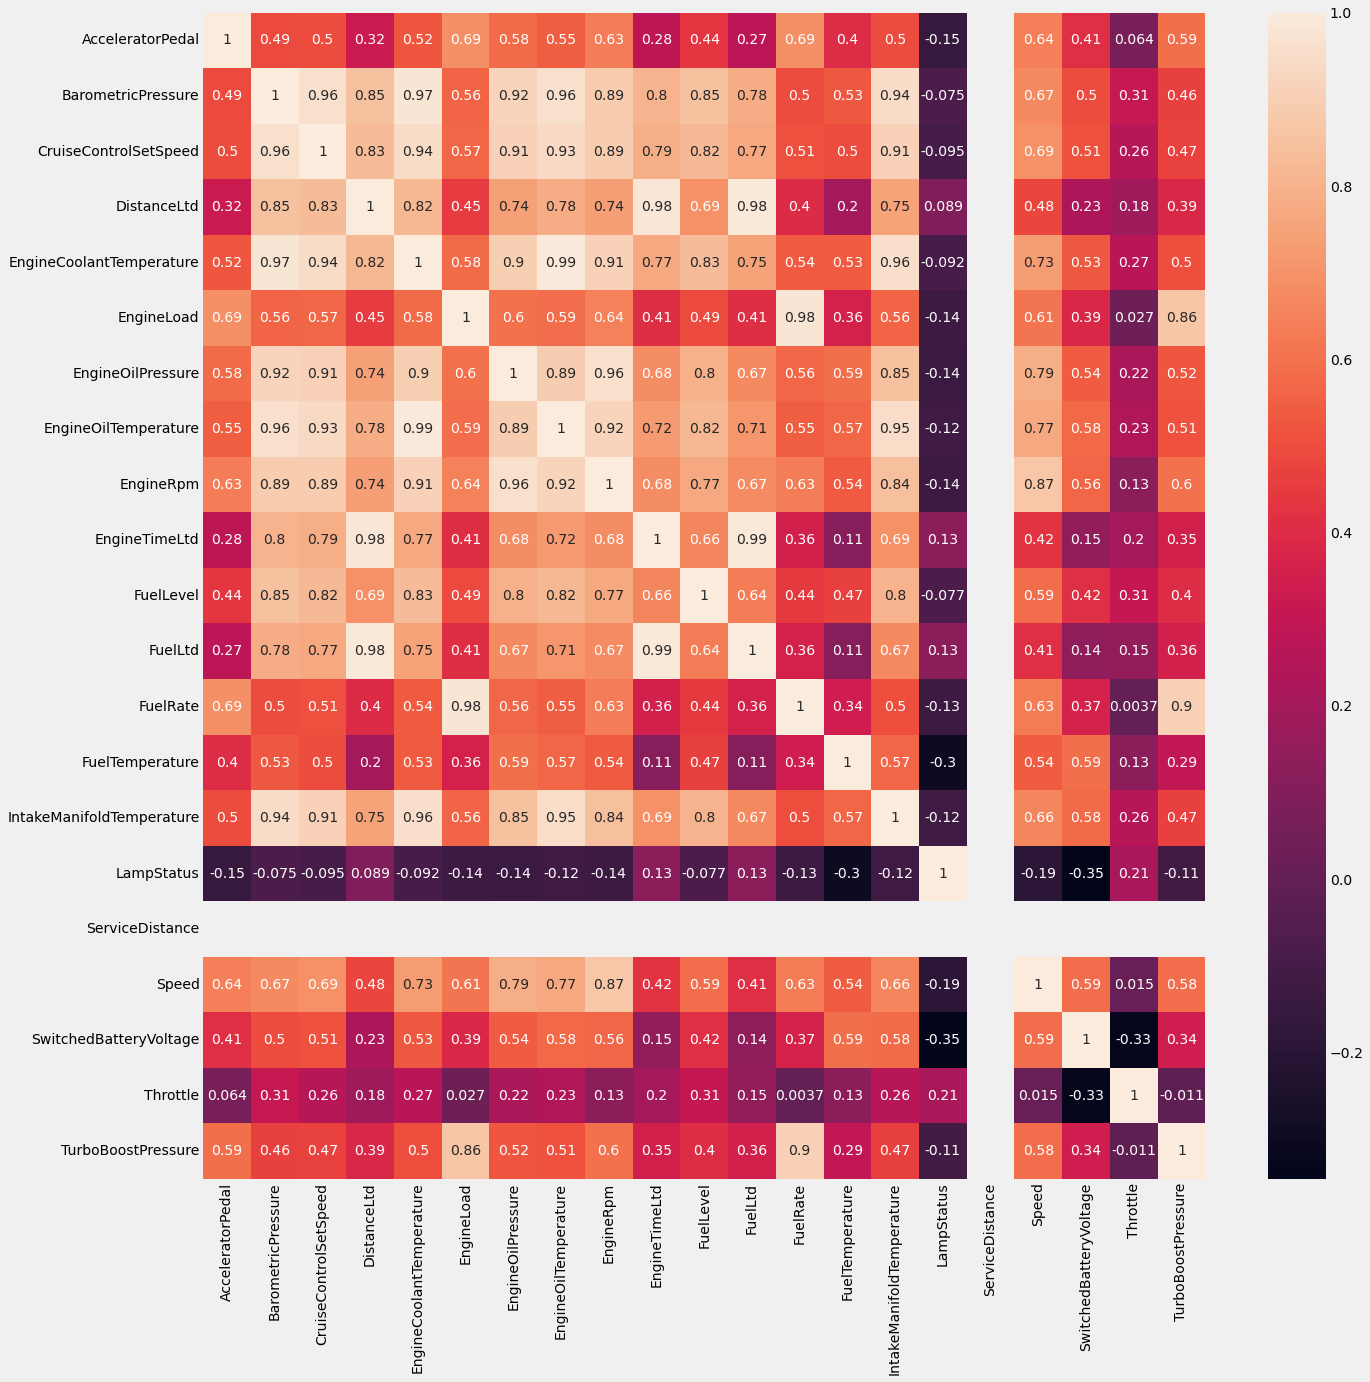

In [46]:
corr = sensors.corr()
top_features = corr.index
plt.figure(figsize=(20,20))
sns.heatmap(sensors[top_features].corr(), annot =True)

In [47]:
threshold = 0.65

In [48]:
def correlation(sensors, threshold):
    col_corr = set() # Set of all the names of correlated columns
    corr_matrix = sensors.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
              if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i] # getting the nhesame of column
                    col_corr.add(colname)
    return col_corr  

In [49]:
correlation(sensors, threshold)

{'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'IntakeManifoldTemperature',
 'Speed',
 'TurboBoostPressure'}

In [80]:
spn_data = dfx_seven_day[['EventTimeStamp', 'EquipmentID', 'spn']]


In [81]:
spn_data.set_index(['EventTimeStamp','EquipmentID'],inplace=True)


In [82]:
spn_data_dedupe = spn_data[~spn_data.index.duplicated(keep='first')]

In [83]:

spn_data_dedupe['spn'] = spn_data_dedupe['spn'].astype(str)

/tmp/ipykernel_4482/1151481815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spn_data_dedupe['spn'] = spn_data_dedupe['spn'].astype(str)


In [84]:
pivoted_spn = pd.pivot(spn_data_dedupe.reset_index(), index=['EventTimeStamp','EquipmentID'], columns='spn', values ='spn')

In [85]:
pivoted_spn

,spn,0,100,102,103,105,1059,1068,110,111,1209,...,802,807,81,829,886,91,929,94,96,97
EventTimeStamp,EquipmentID,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:03:22,2175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 00:03:23,2175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 00:03:34,1751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 00:03:55,1452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 00:04:57,1452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-06 07:45:08,1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-13 08:32:46,1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-13 11:32:18,1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
#pivoted_spn_test  = pivoted_spn.reset_index()

In [86]:
columns = pivoted_spn.columns.to_list()


In [88]:
pivoted_spn['5246']

EventTimeStamp       EquipmentID
2011-01-01 00:03:22  2175           5246
2011-01-01 00:03:23  2175           5246
2011-01-01 00:03:34  1751            NaN
2011-01-01 00:03:55  1452            NaN
2011-01-01 00:04:57  1452            NaN
                                    ... 
2020-02-06 07:45:08  1854           5246
2020-02-13 08:32:46  1872            NaN
2020-02-13 11:32:18  1872            NaN
2020-02-13 12:08:29  1872            NaN
2020-02-13 13:32:39  1872           5246
Name: 5246, Length: 5780, dtype: object

In [89]:
spn_dummies = pd.get_dummies(pivoted_spn)
spn_dummies

,,0_0,100_100,102_102,103_103,105_105,1059_1059,1068_1068,110_110,111_111,1209_1209,...,802_802,807_807,81_81,829_829,886_886,91_91,929_929,94_94,96_96,97_97
EventTimeStamp,EquipmentID,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:03:22,2175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 00:03:23,2175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 00:03:34,1751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 00:03:55,1452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 00:04:57,1452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-06 07:45:08,1854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-13 08:32:46,1872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-13 11:32:18,1872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
spn_seven_day_data = spn_dummies.reset_index()

In [91]:
spn_seven_day_data.columns = ['EventTimeStamp','EquipmentID',
 '0',
 '100',
 '102',
 '103',
 '105',
 '1059',
 '1068',
 '110',
 '111',
 '1209',
 '1231',
 '1483',
 '1569',
 '157',
 '1675',
 '171',
 '175',
 '1761',
 '1807',
 '1808',
 '245',
 '2623',
 '2863',
 '3031',
 '3216',
 '3218',
 '3226',
 '3246',
 '3251',
 '3360',
 '3361',
 '3362',
 '3363',
 '3364',
 '3464',
 '3482',
 '3490',
 '3513',
 '3556',
 '3610',
 '3720',
 '3936',
 '4094',
 '4096',
 '412',
 '4334',
 '4339',
 '4340',
 '4342',
 '4344',
 '4354',
 '4363',
 '4364',
 '4376',
 '4765',
 '5024',
 '50353',
 '520203',
 '520953',
 '523531',
 '524287',
 '5246',
 '5319',
 '5394',
 '5397',
 '5485',
 '5491',
 '5585',
 '563',
 '5742',
 '5743',
 '5746',
 '5835',
 '5848',
 '5851',
 '596',
 '611',
 '612',
 '627',
 '630',
 '639',
 '641',
 '651',
 '653',
 '6802',
 '70',
 '789',
 '790',
 '791',
 '792',
 '793',
 '802',
 '807',
 '81',
 '829',
 '886',
 '91',
 '929',
 '94',
 '96',
 '97']

In [92]:
spn_count = spn_seven_day_data.groupby(['EquipmentID', 'EventTimeStamp']).sum().reset_index()

In [93]:
spn_count.head()

,EquipmentID,EventTimeStamp,0,100,102,103,105,1059,1068,110,...,802,807,81,829,886,91,929,94,96,97
0,1329,2015-02-25 13:53:08,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1339,2015-06-07 07:50:25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1339,2015-06-07 10:14:02,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1339,2015-06-07 10:16:47,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1339,2015-06-07 14:31:16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
spn_count.describe()

,0,100,102,103,105,1059,1068,110,111,1209,...,802,807,81,829,886,91,929,94,96,97
count,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,...,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000
mean,0.000173,0.000346,0.001384,0.000346,0.001384,0.002768,0.011938,0.000692,0.357958,0.001557,...,0.000692,0.000346,0.000519,0.069031,0.000519,0.000692,0.026298,0.000346,0.142388,0.004152
std,0.013153,0.018600,0.037181,0.018600,0.037181,0.052545,0.108615,0.026300,0.479441,0.039433,...,0.026300,0.018600,0.022778,0.253529,0.022778,0.026300,0.160033,0.018600,0.349477,0.064310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
temp = []


for col in spn_count.columns[2:6]:

    temp.append(pd.pivot_table(spn_count,

                               index='EventTimeStamp',

                               columns='EquipmentID',

                               values=col).rolling(window='1D').sum().resample('3H',

                                                                             closed='left',

                                                                             label='right').first().unstack())
error_count = pd.concat(temp, axis=1)

error_count.columns = spn_count.columns[2:6]

error_count.reset_index(inplace=True)

error_count = error_count.dropna()

error_count.describe()

,0,100,102,103
count,1946.000000,1946.000000,1946.000000,1946.000000
mean,0.003597,0.003083,0.008736,0.002055
std,0.059883,0.078487,0.103540,0.045303
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.000000,2.000000,1.000000


In [ ]:
# calculating cross sectional stats for time delta between spn codes per a truck 
# filtering events that occurred less than 30 times so that stdev is statitically significant
result = []
for spn in dfx_seven_day['spn'].unique():
    try:
        temp = dfx_seven_day.loc[(dfx_seven_day['spn'] == spn) & (dfx_seven_day['flipper']!=1),"EventTimeStamp"].diff().apply(lambda x: x/np.timedelta64(1, 'D')).fillna(0).astype('int64')
    except Exception as ex:
        print(ex)
        print(spn)
        break
            
    filtered_temp = temp[temp > 0]
    spn_dev = filtered_temp.std()
    spn_mean=filtered_temp.mean()
    result.append((spn, len(filtered_temp),spn_mean, spn_dev))
spn_stats = pd.DataFrame(result, columns = ['spn','sample_size', 'spn_mean', 'spn_dev'])
spn_stats.loc[spn_stats['sample_size'] > 30,:].sort_values(['spn_dev'], ascending=True)

In [ ]:
seven_day_data[['EventTimeStamp','spn']].groupby('spn')['EventTimeStamp'].hist()